In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DeepAR

In [ ]:
%%capture
%pip install gluonts
%pip install pytorch-lightning
!pip install --upgrade mxnet==1.6.0
!pip install "gluonts[torch]"

In [ ]:
import os
import matplotlib as mpl
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator
from typing import Dict

In [ ]:
train = pd.read_csv("/content/train_sfo_processed.csv")
test = pd.read_csv("/content/test_sfo_processed.csv")

In [ ]:
train

,year,week,week_beg,revenue,quantity,month,month_revenue,150_r,50_r,500_r,...,12_competitor_tv_reg,12_competitor_total,13_competitor_rating,13_competitor_coverage,13_competitor_money,13_competitor_digital,13_competitor_sponsorship_money,13_competitor_oon_money,13_competitor_radio_money,13_competitor_total
0,2019,1,15462144,4.153557e+07,114621.15,12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.155664e+06,1.183425e+07,207.903106,15.3615,9085528.010322582,0.0,0.0,0.0,0.0,9.085528e+06
1,2019,2,15468192,5.122229e+07,141523.20,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.348274e+06,1.399653e+07,317.467542,25.5255,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07
2,2019,3,15474240,5.712735e+07,157926.30,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.348274e+06,1.146629e+07,192.816682,13.9125,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07
3,2019,4,15480288,6.304099e+07,173746.65,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.348274e+06,1.076463e+07,138.371621,8.0535,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07
4,2019,5,15486336,6.733689e+07,185551.80,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.477038e+06,1.098497e+07,286.984113,24.2235,12893092.405548388,0.0,0.0,0.0,0.0,1.289309e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2023,31,16907616,5.693151e+07,110088.30,7,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,...,0.000000e+00,0.000000e+00,0.000000,0.0000,0,0.0,0.0,0.0,0.0,0.000000e+00
240,2023,32,16913664,5.988151e+07,115345.65,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,...,0.000000e+00,0.000000e+00,0.000000,0.0000,0,0.0,0.0,0.0,0.0,0.000000e+00
241,2023,33,16919712,6.111218e+07,117761.70,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,...,0.000000e+00,6.939450e+04,0.000000,0.0000,0,0.0,0.0,0.0,0.0,0.000000e+00
242,2023,34,16925760,6.159493e+07,118356.00,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,...,0.000000e+00,7.852950e+04,0.000000,0.0000,0,0.0,0.0,0.0,0.0,0.000000e+00


In [ ]:
test_y = train.iloc[215:, 3].values
train_y = train.iloc[:215, 3].values

In [ ]:
train_feat = train.iloc[215:].drop(columns=["revenue"])
test_feat = train.iloc[:215].drop(columns=["revenue"])

In [ ]:
train_feat.columns = range(0, train_feat.shape[1])
test_feat.columns = range(0, test_feat.shape[1])

In [ ]:
train_feat = train_feat.drop(columns=train_feat.select_dtypes("object").columns).values
test_feat = test_feat.drop(columns=test_feat.select_dtypes("object").columns).values

In [ ]:
train_start = pd.Timestamp("12/31/2018")
test_start = pd.Timestamp("2/13/2023")
train_ds = ListDataset([{"start" : train_start, "target" : train_y, "dynamic_feat" : train_feat}], freq="W")
test_ds = ListDataset([{"start" : test_start, "target" : test_y, "dynamic_feat" : test_feat}], freq="W")

In [ ]:
estimator = DeepAREstimator(freq="W",
                            prediction_length=29,
                            num_layers=3,
                            hidden_size=128,
                            dropout_rate=0,
                            trainer_kwargs={'max_epochs': 20}
                            )

In [ ]:
predictor = estimator.train(training_data=train_ds, num_workers=4)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                                      | Out sizes   
------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 17.62882 (best 17.62882), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 17.62882 (best 17.62882), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 17.31112 (best 17.31112), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 17.31112 (best 17.31112), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 17.04031 (best 17.04031), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global s

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=5,
)

In [ ]:
print("Gathering time series predictions ...")
forecasts = list(forecast_it)

Gathering time series predictions ...


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

mape = mean_absolute_percentage_error(test_y, preds.reshape(1,29 )[0])
r2 = r2_score(test_y, preds.reshape(1,29 )[0])

In [ ]:
print(mape, r2)

1.0 -164.06994825050523


# Catboost Feature Importance

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/content/train_sfo_processed.csv")

In [ ]:
X = train.drop(columns=["revenue"])
y = train[["revenue"]]

In [ ]:
gbm = CatBoostRegressor(iterations=100, )

In [ ]:
gbm.fit(X, y, verbose=300)

Learning rate set to 0.213004
0:	learn: 19248252.2247775	total: 4.91ms	remaining: 486ms
99:	learn: 661841.6883703	total: 440ms	remaining: 0us


In [ ]:
values = sorted(gbm.feature_importances_, reverse=True)
features_ids = sorted(range(len(X.columns)), reverse=True, key = lambda x: gbm.feature_importances_[x])

In [ ]:
pd.Series(X.columns[features_ids]).to_csv("importances_.csv", index=False)

<BarContainer object of 5 artists>

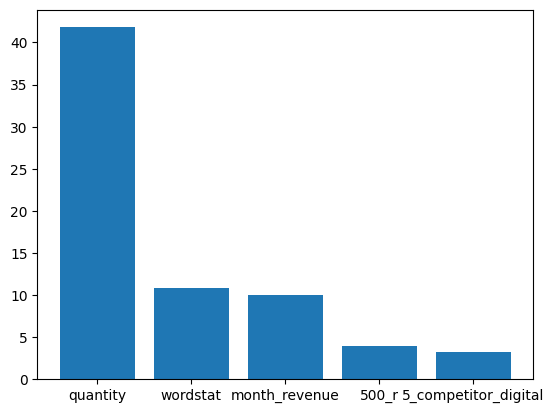

In [ ]:
plt.bar(X.columns[features_ids], values)

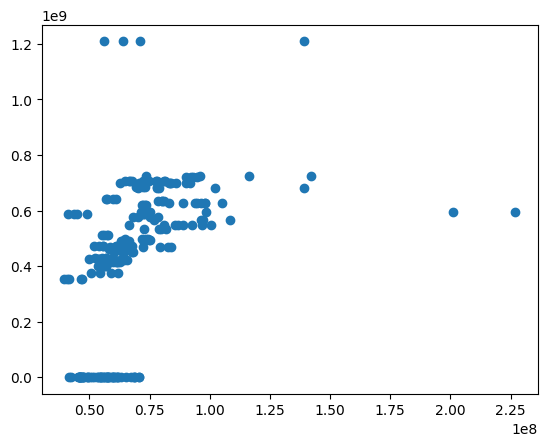

In [ ]:
plt.scatter(train["revenue"], train["month_revenue"])

In [ ]:
plt.scatter(train["revenue"], train["quantity"])